<a href="https://colab.research.google.com/github/Gradsmith/Deep-Learning-HW4/blob/main/DL2022_HW4_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (GRU, LSTM, Bidirectional, Dense, Dropout, Embedding,
                          Flatten, Input, RepeatVector, TimeDistributed)
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import seaborn as sns

In [ ]:
# Download ferdousi.txt from drive.
!gdown 1aRxzZTQnxL1N3d2Pii6H461FjjQk6hNN

Downloading...
From: https://drive.google.com/uc?id=1aRxzZTQnxL1N3d2Pii6H461FjjQk6hNN
To: /content/ferdousi.txt
100% 4.54M/4.54M [00:00<00:00, 22.1MB/s]


In [ ]:
# Read the entire text file.
with open ('./ferdousi.txt', 'r') as f:
    dataset = f.read().split('\n')

In [ ]:
# Seperate beyts and split them into odd and even beyts for encoder and decoder inputs.
beyts = []
for i in range(int(len(dataset)/2)-1):
    beyts.append(dataset[2+2*i]+' '+dataset[2+2*i+1])

beyts_in = beyts[0::2]
beyts_out = beyts[1::2]

In [ ]:
# Define a Keras tokenizer and fit it on the beyts.
tokenizer = Tokenizer()

tokenizer.fit_on_texts(beyts)
vocab_size = len(tokenizer.word_index) + 1

Now, we plot the histogram of number of words in beyts and select an appropriate length to pad all beyts based on the histogram.

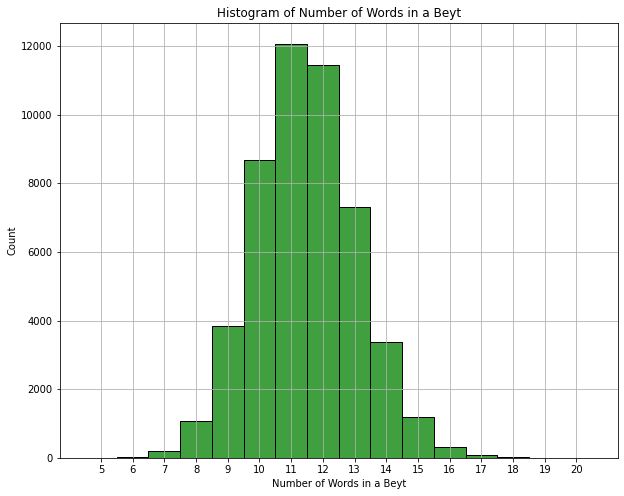

In [ ]:
h = sorted([len(b.split()) for b in beyts])
h = [str(i) for i in h]
plt.figure(figsize=(10, 8))
sns.histplot(h, color='green')
plt.grid()
plt.xlabel('Number of Words in a Beyt')
plt.title('Histogram of Number of Words in Beyts')
plt.show()

As can be seen, most of the beyts have a length of shorter than 17 words, so we choose 16 as our max padding length.

In [ ]:
max_seq_len = 16

In [ ]:
# Convert texts to sequences with the tokenizer.
beyts_in = tokenizer.texts_to_sequences(beyts_in)
beyts_in = pad_sequences(beyts_in, maxlen=max_seq_len, padding='post')

beyts_out = tokenizer.texts_to_sequences(beyts_out)
beyts_out = pad_sequences(beyts_out, maxlen=max_seq_len, padding='post')

# Create a shifted version of decoder outputs to use for teacher forcing.
beyts_out_tf = np.zeros(beyts_out.shape, dtype=np.int32)
beyts_out_tf[:, 1:] = beyts_out[:, :-1]

# Part A: LSTM

In this part we define an encoder-decoder model with LSTM modules and train it with teacher forcing method. The words are embedded to a 256D space with an embedding layer.

In [ ]:
n_embed = 256

# Training encoder
encoder_inputs = Input(shape=(max_seq_len))
embedding_layer = Embedding(vocab_size, n_embed, input_length=max_seq_len, mask_zero=True)
encoder_inputs_embedded = embedding_layer(encoder_inputs)
encoder = LSTM(n_embed, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_embedded)
encoder_states = [state_h, state_c]
# Training decoder
decoder_inputs = Input(shape=(max_seq_len))
decoder_inputs_embedded = embedding_layer(decoder_inputs)
decoder = LSTM(n_embed, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs_embedded, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# Inference encoder
encoder_model = Model(encoder_inputs, encoder_states)
# Inference decoder
decoder_state_input_h = Input(shape=(n_embed))
decoder_state_input_c = Input(shape=(n_embed))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder(decoder_inputs_embedded, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
# Use ADAM as the optimizer and accuracy as the metric.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print the model architecture.
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 256)      4609792     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 256),        525312      ['embedding[0][0]']          

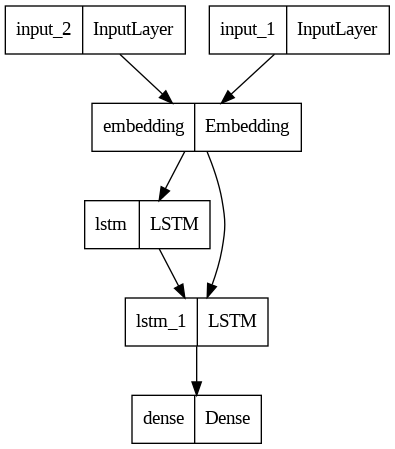

In [ ]:
# Plot the model architecture.
plot_model(model, to_file='LSTM.png')

In [ ]:
# Train the model.
history = model.fit([beyts_in, beyts_out_tf], beyts_out, validation_split=0.2, epochs=50, batch_size=128)

Epoch 1/50
156/156 [==============================] - 32s 130ms/step - loss: 5.0539 - accuracy: 0.0969 - val_loss: 4.8183 - val_accuracy: 0.1076
Epoch 2/50
156/156 [==============================] - 17s 109ms/step - loss: 4.6332 - accuracy: 0.1158 - val_loss: 4.7098 - val_accuracy: 0.1196
Epoch 3/50
156/156 [==============================] - 17s 106ms/step - loss: 4.4585 - accuracy: 0.1327 - val_loss: 4.6113 - val_accuracy: 0.1364
Epoch 4/50
156/156 [==============================] - 17s 107ms/step - loss: 4.3128 - accuracy: 0.1488 - val_loss: 4.5399 - val_accuracy: 0.1475
Epoch 5/50
156/156 [==============================] - 17s 106ms/step - loss: 4.1796 - accuracy: 0.1620 - val_loss: 4.4455 - val_accuracy: 0.1572
Epoch 6/50
156/156 [==============================] - 17s 107ms/step - loss: 4.0490 - accuracy: 0.1744 - val_loss: 4.3739 - val_accuracy: 0.1643
Epoch 7/50
156/156 [==============================] - 17s 107ms/step - loss: 3.9292 - accuracy: 0.1840 - val_loss: 4.3182 - val_ac

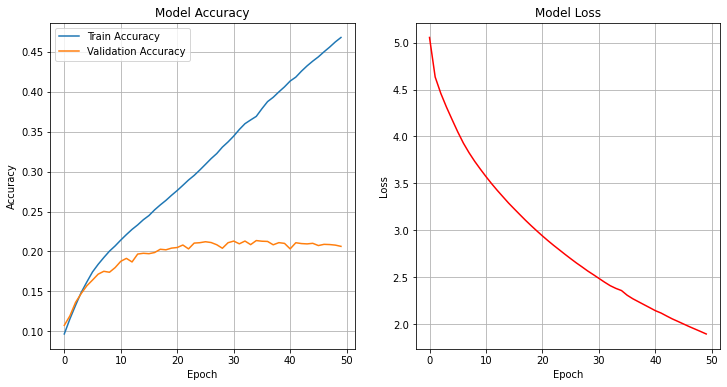

In [ ]:
# Plot accuracy and loss vs epoch.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()

plt.show()

In [ ]:
# Define a function to generate new sequences of data given an input sequence.
def generate_sequence(infenc, infdec, source_text, n_steps, temprature=1):
    # Tokenize source text. 
    input = tokenizer.texts_to_sequences([source_text])[0]
    input = pad_sequences([input], maxlen=max_seq_len, padding='post')
    # Encode the input and compute the states of the encoder.
    state = infenc.predict(input, verbose=0)
    # Start of sequence input for the decoder.
    target_seq = np.zeros((1, max_seq_len))
    # Collect predictions.
    output = []
    for t in range(n_steps):
        # Predict next word.
        yhat, h, c = infdec.predict([target_seq] + state, verbose=0)
        # Sample from the decoder output.
        p = np.exp(np.log(yhat[0,0,:])/temprature)
        p = p/np.sum(p)
        sample = np.random.choice(vocab_size, p=p)
        output.append(sample)
        # Update states.
        state = [h, c]
        # Update target sequence.
        target_seq = np.ones((1, max_seq_len)) * sample
    return np.array(output)

In [ ]:
# Generate beyts for some random given inputs.
idxs = np.random.default_rng(seed=123).integers(len(beyts), size=5)

for i in idxs:
    l = len(beyts[i].split())
    beyt_gen = generate_sequence(encoder_model, decoder_model, beyts[i], l)
    beyt_gen = tokenizer.sequences_to_texts([beyt_gen+1])
    print('Input Beyt:')
    print(beyts[i])
    print('Generated Beyt:')
    print(beyt_gen[0])
    print('\n')

Input Beyt:
همی زین فزون بایدم لشکری هم از مردم و هم ز دیو و پری
Generated Beyt:
یازند این و اینسان و نسازد و گرفتار و تیرها و داناترید و گلستانست


Input Beyt:
چو نزدیکی چشمهٔ سو رسید برون آمد از مهد و دریا بدید
Generated Beyt:
دایگانش میش و منظرش و بخفتان و درخشان و گروگان و مکش


Input Beyt:
ترا گفتم از دانش آسمان زدایم دلت تا شوی بی گمان
Generated Beyt:
هل بد و مرده و درآشتی و توبخت و آسوده و


Input Beyt:
میان سپهدار و آن سرو بن زنی بود گوینده شیرین سخن
Generated Beyt:
آگند آفرین و دوده و وتوشه و بمشت و گوار و


Input Beyt:
شناسد که این تخت و این فرهی کرا بود و دیهیم شاهنشهی
Generated Beyt:
داشت روی و شگفتید و زندانها و نخشب و پیرداننده و باکس




In [ ]:
# Save the models.
model.save('model_lstm.h5')
encoder_model.save('encoder_model_lstm.h5')
decoder_model.save('decoder_model_lstm.h5')

# Part B: Bidirectional GRU

Now, we define an encoder-decoder model with bidirectional GRU modules and train it with teacher forcing method. Like the previous part, we use a 256D space for embedding words.

In [ ]:
n_embed = 256

# Training encoder
encoder_inputs = Input(shape=(max_seq_len))
embedding_layer = Embedding(vocab_size, n_embed, input_length=max_seq_len, mask_zero=True)
encoder_inputs_embedded = embedding_layer(encoder_inputs)
encoder = Bidirectional(GRU(n_embed, return_state=True))
encoder_outputs, state_h, state_c = encoder(encoder_inputs_embedded)
encoder_states = [state_h, state_c]
# Training decoder
decoder_inputs = Input(shape=(max_seq_len))
decoder_inputs_embedded = embedding_layer(decoder_inputs)
decoder = Bidirectional(GRU(n_embed, return_sequences=True, return_state=True))
decoder_outputs, _, _ = decoder(decoder_inputs_embedded, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# Inference encoder
encoder_model = Model(encoder_inputs, encoder_states)
# Inference decoder
decoder_state_input_h = Input(shape=(n_embed))
decoder_state_input_c = Input(shape=(n_embed))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder(decoder_inputs_embedded, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
# Use ADAM as the optimizer and accuracy as the metric.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print the model architecture.
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 16, 256)      4609792     ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 bidirectional_2 (Bidirectional  [(None, 512),       789504      ['embedding_2[0][0]']      

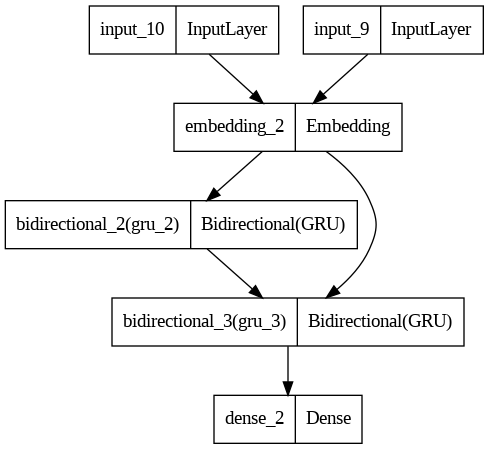

In [ ]:
# Plot the model architecture.
plot_model(model, to_file='BiGRU.png')

In [ ]:
# Train the model.
history = model.fit([beyts_in, beyts_out_tf], beyts_out, validation_split=0.2, epochs=25, batch_size=128)

Epoch 1/25
156/156 [==============================] - 42s 190ms/step - loss: 4.7435 - accuracy: 0.1400 - val_loss: 3.9827 - val_accuracy: 0.1926
Epoch 2/25
156/156 [==============================] - 25s 159ms/step - loss: 3.1188 - accuracy: 0.3321 - val_loss: 2.5977 - val_accuracy: 0.4873
Epoch 3/25
156/156 [==============================] - 25s 159ms/step - loss: 1.7961 - accuracy: 0.6252 - val_loss: 1.7309 - val_accuracy: 0.6942
Epoch 4/25
156/156 [==============================] - 25s 161ms/step - loss: 1.0567 - accuracy: 0.7886 - val_loss: 1.3332 - val_accuracy: 0.7885
Epoch 5/25
156/156 [==============================] - 25s 160ms/step - loss: 0.6532 - accuracy: 0.8703 - val_loss: 1.1338 - val_accuracy: 0.8333
Epoch 6/25
156/156 [==============================] - 25s 161ms/step - loss: 0.4043 - accuracy: 0.9211 - val_loss: 1.0422 - val_accuracy: 0.8559
Epoch 7/25
156/156 [==============================] - 25s 159ms/step - loss: 0.2344 - accuracy: 0.9640 - val_loss: 0.9824 - val_ac

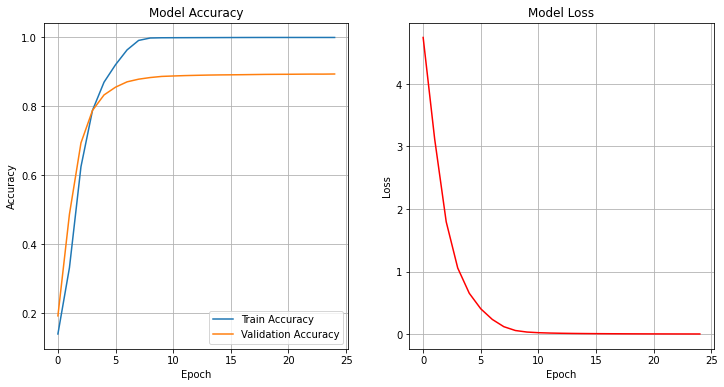

In [ ]:
# Plot accuracy and loss vs epoch.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()

plt.show()

We can see that this model has a much higher/lower accuracy/loss compared to the LSTM model. This improvment can be due to the fact that this model has a bidirectional architecture and thus it can better understand the semantic relationship between the words of a beyt.

In [ ]:
# Generate beyts for some random given inputs.
idxs = np.random.default_rng(seed=123).integers(len(beyts), size=5)

for i in idxs:
    l = len(beyts[i].split())
    beyt_gen = generate_sequence(encoder_model, decoder_model, beyts[i], l, 4)
    beyt_gen = tokenizer.sequences_to_texts([beyt_gen+1])
    print('Input Beyt:')
    print(beyts[i])
    print('Generated Beyt:')
    print(beyt_gen[0])
    print('\n')

Input Beyt:
همی زین فزون بایدم لشکری هم از مردم و هم ز دیو و پری
Generated Beyt:
بردرد جاروب بشکنی جویبارست وخیل کراشاد آبتین بدوخت سانست یکدگر جنگست فرمانروا سرای دومنزل


Input Beyt:
چو نزدیکی چشمهٔ سو رسید برون آمد از مهد و دریا بدید
Generated Beyt:
بازشو آشناه دورش زمرد ارد آنکس بکینه بدانی بدسگال بازجست باده یابند


Input Beyt:
ترا گفتم از دانش آسمان زدایم دلت تا شوی بی گمان
Generated Beyt:
نمود پوست رخ هرسو سیندخت زرور نماندی کینهٔ نیارست لشکرش دانیم


Input Beyt:
میان سپهدار و آن سرو بن زنی بود گوینده شیرین سخن
Generated Beyt:
افسانه بیناد کردوچه دشمنند ومسکین نشستنش ازار کت برافراخت زبانگ بارکن


Input Beyt:
شناسد که این تخت و این فرهی کرا بود و دیهیم شاهنشهی
Generated Beyt:
جریره بدتنست فرایندهٔ گزاریدن نامبردار خونشان شدی بخشودنیست نبودی پهلوست کنارنگ پران




Although the model has a high accuracy, we can see that the generated beyts don't sound natural. We can improve the generated beyts by using other methods (e.g., n-grams) and architectures to build and train a better model.

In [ ]:
# Save the models.
model.save('model_bigru.h5')
encoder_model.save('encoder_model_bigru.h5')
decoder_model.save('decoder_model_bigru.h5')